### Работу выполнил Брунов Даниил, студент 3825М1сФИ1
### Выбрано изображение: **IMG_3028**

Задание:
1. С помощью opencv найти угловые точки документа
2. зная угловые точки сделать перспективную трансформацию для того чтобы выровнять документ (можно использовать функцию wrapperspective)
3. На выровненном изображении документа почитать количество строк и символов


In [26]:
# импорт всего что нужно для работы
import cv2
import numpy as np
import matplotlib.pyplot as plt


Размер изображения: (4032, 3024, 3)


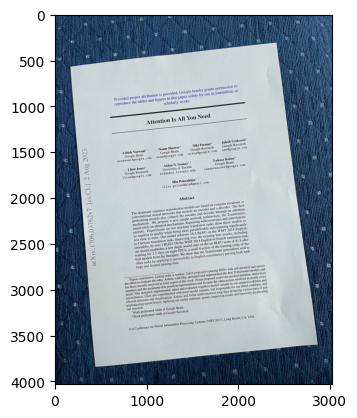

In [28]:
# загрузка документа
img = cv2.imread('/content/IMG_3028.jpeg')
orig_img = img.copy()
print(f"Размер изображения: {img.shape}")
plt.imshow(img)

### Поиск угловых точек

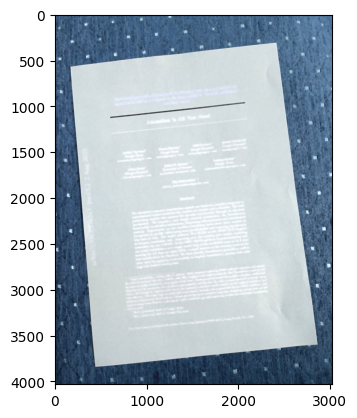

In [29]:
# очистка изображения документа от содержания для корректной дальнейшей работы
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.imshow(img)

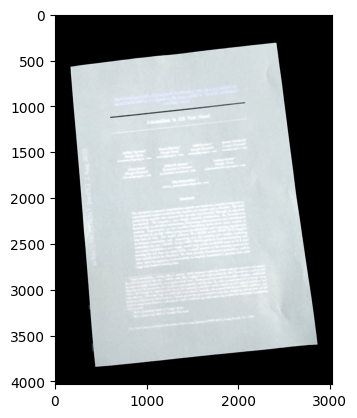

In [30]:
# удаление фона с grabCut
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img)

In [31]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)

# обнаружение краев
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

# обнаружение контура
con = np.zeros_like(img)

contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

In [32]:
# определение самих угловых точек
con = np.zeros_like(img)
for c in page:
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
corners = sorted(np.concatenate(corners).tolist())

for index, c in enumerate(corners):
  character = chr(65 + index)
  cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

### Выравнивание документа

In [33]:
# вспомогательная функция для сортировки последовательности угловых точек
def order_points(pts):
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect.astype('int').tolist()

In [34]:
# вспомогательная функция для координат назначения для выполнения перспективного преобразования и выравнивания документа
def find_dest(pts):
    (tl, tr, br, bl) = pts
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)

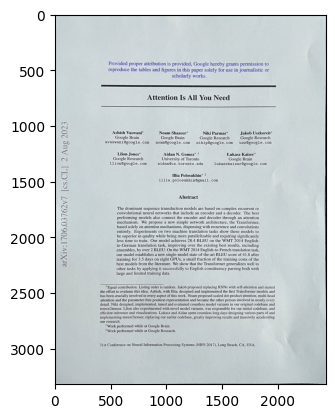

In [35]:
# выравнивание документа
if len(page) == 0:
    orig_img
for c in page:
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    if len(corners) == 4:
        break
corners = sorted(np.concatenate(corners).tolist())
corners = order_points(corners)

destination_corners = find_dest(corners)

h, w = orig_img.shape[:2]
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
plt.imshow(final)

In [13]:
# выгрузка в файл финального документа
# from google.colab import files

# cv2.imwrite('document.jpg', final)
# files.download('document.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Считаем количество строк и символов

In [36]:
gray = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)

# используем алгоритм MSER для детекции текстовых блоков
mser = cv2.MSER_create()
mser.setDelta(2)
mser.setMinArea(3)
mser.setMaxArea(150)
mser.setMaxVariation(0.8)

regions, _ = mser.detectRegions(gray)
print(f"Найдено MSER регионов: {len(regions)}")

Найдено MSER регионов: 159759


После строгой фильтрации: 30843 символов


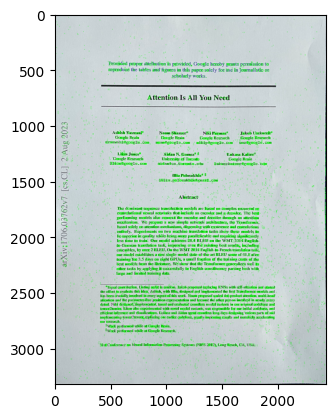

In [37]:
# Строгая фильтрация для выделения отдельных символов
def strict_character_filter(regions):
    boxes = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        if w < 2 or h < 5: continue  # Слишком маленькие
        if w > 25 or h > 25: continue  # Слишком большие (скорее слова)
        if w / h < 0.2 or w / h > 2.0: continue  # Строгое соотношение сторон

        # Фильтр по плотности региона
        region_area = w * h
        contour_area = cv2.contourArea(region)
        density = contour_area / region_area if region_area > 0 else 0
        if density < 0.2 or density > 0.9: continue  # Слишком разреженные или плотные
        boxes.append((x, y, w, h))
    return boxes

filtered_boxes = strict_character_filter(regions)
print(f"После строгой фильтрации: {len(filtered_boxes)} символов")

# Визуализация
char_vis = final.copy()
for (x, y, w, h) in filtered_boxes:
    cv2.rectangle(char_vis, (x, y), (x + w, y + h), (0, 255, 0), 1)
plt.imshow(char_vis)

In [38]:
# Группировка в строки без объединения символов
def line_grouping_no_merge(boxes, image_height, line_threshold=8):
    if not boxes:
        return []
    histogram = np.zeros(image_height) # Создаем гистограмму вертикальных позиций
    for x, y, w, h in boxes:
        center_y = y + h // 2
        histogram[center_y] += 1
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    smoothed_hist = np.convolve(histogram, kernel, mode='same')

    # Находим пики (строки)
    threshold = np.max(smoothed_hist) * 0.3
    peaks = []
    for i in range(1, len(smoothed_hist) - 1):
        if (smoothed_hist[i] > threshold and
            smoothed_hist[i] > smoothed_hist[i-1] and
            smoothed_hist[i] > smoothed_hist[i+1]):
            peaks.append(i)

    # Группируем близкие пики
    merged_peaks = []
    for peak in sorted(peaks):
        if not merged_peaks:
            merged_peaks.append([peak])
        else:
            last_group = merged_peaks[-1]
            if peak - last_group[-1] < line_threshold:
                last_group.append(peak)
            else:
                merged_peaks.append([peak])

    # Средние позиции строк
    line_centers = [int(np.mean(group)) for group in merged_peaks]

    # Группируем символы по строкам
    lines = [[] for _ in line_centers]

    for box in boxes:
        x, y, w, h = box
        center_y = y + h // 2

        # Находим ближайшую строку
        min_dist = float('inf')
        best_line = -1
        for i, line_center in enumerate(line_centers):
            dist = abs(center_y - line_center)
            if dist < min_dist and dist < 10:  # Максимальное расстояние до строки
                min_dist = dist
                best_line = i
        if best_line != -1:
            lines[best_line].append(box)

    # Удаляем пустые строки и сортируем
    lines = [line for line in lines if line]
    lines.sort(key=lambda line: np.mean([y for x, y, w, h in line]))
    for line in lines:
        line.sort(key=lambda box: box[0])

    return lines, smoothed_hist

# Группируем в строки без объединения
lines, hist = line_grouping_no_merge(filtered_boxes, final.shape[0])
print(f"Обнаружено строк: {len(lines)}")

Обнаружено строк: 32


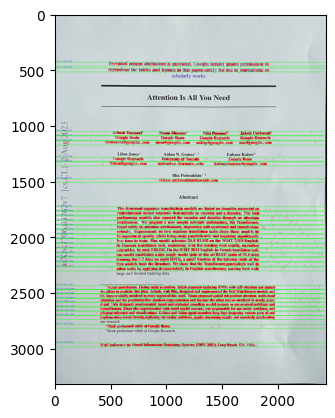

In [39]:
# Визуализируем строки с отдельными символами
lines_vis = final.copy()

for i, line in enumerate(lines):
    # Вычисляем границы строки
    y_coords = [box[1] for box in line]
    y_ends = [box[1] + box[3] for box in line]
    start_y = min(y_coords)
    end_y = max(y_ends)

    cv2.rectangle(lines_vis, (0, start_y), (final.shape[1], end_y), (0, 255, 0), 2)

    # Рисуем КАЖДЫЙ символ отдельно
    for j, (x, y, w, h) in enumerate(line):
        cv2.rectangle(lines_vis, (x, y), (x + w, y + h), (255, 0, 0), 1)

        if j < 20:
            cv2.putText(lines_vis, str(j+1), (x + 2, y + h - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

    # Подписываем строку
    cv2.putText(lines_vis, f'Line {i+1}: {len(line)} chars', (10, start_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

plt.imshow(lines_vis)

In [40]:
# Разделяем возможно слипшиеся символы
def split_merged_characters(boxes, max_char_width=15):
    split_boxes = []
    for (x, y, w, h) in boxes:
        if w > max_char_width:
            num_parts = max(2, int(w / max_char_width) + 1)
            part_width = w // num_parts

            for i in range(num_parts):
                new_x = x + i * part_width
                new_w = part_width if i < num_parts - 1 else w - i * part_width
                if new_w >= 3:
                    split_boxes.append((new_x, y, new_w, h))
        else:
            split_boxes.append((x, y, w, h))

    return split_boxes

# Применяем разделение к всем строкам
split_lines = []
for line in lines:
    split_line = split_merged_characters(line)
    split_lines.append(split_line)

original_count = sum(len(line) for line in lines)
split_count = sum(len(line) for line in split_lines)
# результаты разделения слипшихся символов
print(f"Было: {original_count} символов")
print(f"Стало: {split_count} символов")
print(f"Разделено: {split_count - original_count} символов")

Было: 25843 символов
Стало: 28269 символов
Разделено: 2426 символов


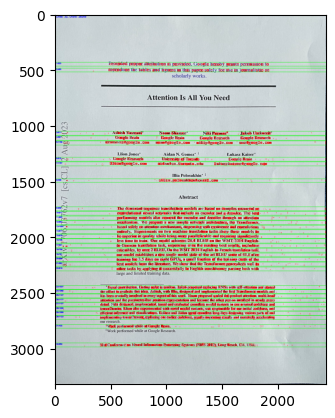

In [41]:
# Финальная визуализация с разделенными символами
final_vis = final.copy()
total_chars = 0

for i, line in enumerate(split_lines):
    if not line:
        continue

    # Вычисляем границы строки
    y_coords = [box[1] for box in line]
    y_ends = [box[1] + box[3] for box in line]
    start_y = min(y_coords)
    end_y = max(y_ends)

    # Рисуем bounding box строки
    cv2.rectangle(final_vis, (0, start_y), (final.shape[1], end_y), (0, 255, 0), 2)

    # Рисуем каждый символ
    for j, (x, y, w, h) in enumerate(line):
        cv2.rectangle(final_vis, (x, y), (x + w, y + h), (255, 0, 0), 1)

    # Подписываем строку
    char_count = len(line)
    total_chars += char_count
    cv2.putText(final_vis, f'{i+1}:{char_count}', (10, start_y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

cv2.putText(final_vis, f'Lines: {len(split_lines)}, Chars: {total_chars}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
plt.imshow(final_vis)

# Сохраняем результата отдельным файлом
# cv2.imwrite('counting_symbols.jpg', final_vis)
# files.download('counting_symbols.jpg')

In [44]:
# Общая статистика детекции по документу

# Анализ распределения символов по строкам
line_stats = []
all_char_widths = []
all_char_heights = []

for i, line in enumerate(split_lines):
    if not line:
        continue

    char_count = len(line)
    widths = [w for x, y, w, h in line]
    heights = [h for x, y, w, h in line]
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)

    line_stats.append({
        'line': i + 1,
        'chars': char_count,
        'avg_width': avg_width,
        'avg_height': avg_height,
        'start_y': min([y for x, y, w, h in line])
    })

    all_char_widths.extend(widths)
    all_char_heights.extend(heights)

# Сортируем по позиции Y
line_stats.sort(key=lambda x: x['start_y'])

print(f"Всего строк: {len(line_stats)}")
print(f"Всего символов: {total_chars}")
print(f"Средняя ширина символа: {np.mean(all_char_widths):.1f}px")
print(f"Средняя высота символа: {np.mean(all_char_heights):.1f}px")
print(f"Медианная ширина символа: {np.median(all_char_widths):.1f}px")
print(f"Медианная высота символа: {np.median(all_char_heights):.1f}px")

Всего строк: 32
Всего символов: 28269
Средняя ширина символа: 7.6px
Средняя высота символа: 14.9px
Медианная ширина символа: 8.0px
Медианная высота символа: 16.0px


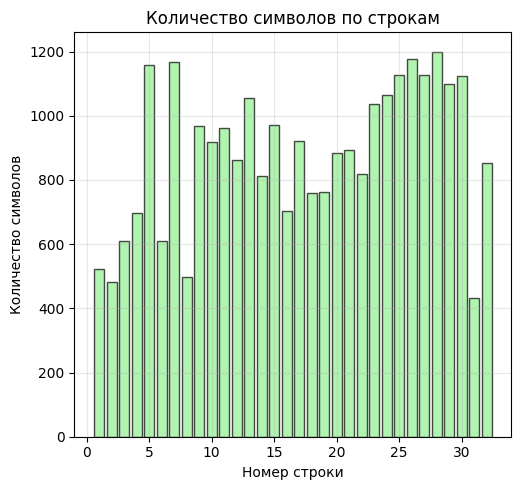

In [45]:
# Анализ размеров символов
plt.figure(figsize=(15, 5))

# Визуализация количества символов по строкам
plt.subplot(1, 3, 3)
line_numbers = [stat['line'] for stat in line_stats]
char_counts = [stat['chars'] for stat in line_stats]
plt.bar(line_numbers, char_counts, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Номер строки')
plt.ylabel('Количество символов')
plt.title('Количество символов по строкам')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()